# Group 1

**공유드라이브 링크**
https://drive.google.com/drive/folders/1V9MqUQUltjv85btDuDi5nRTPyyI58YM9?usp=sharing



## 1. Preparation

### (1) Import packages

In [1]:
import os
from typing import Tuple, List, Sequence, Callable

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset

!pip install -U git+https://github.com/albu/albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import time

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-f9efg4fa
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-f9efg4fa
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=5add450067a68b5d8615faae59f0d900325eec771c50d24053f0d6fe1b0bff9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzp6oo_f/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### (2) Google Drive Colab 연결

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# share drive 를 사용할 경우, /content/drive/Shared drive
os.chdir('/content/drive/My Drive/statml_competition/')

### (3) Setting

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [7]:
device = "cuda:0"
dtype = torch.float
ltype = torch.long # entropy

## 1. 데이터 로드

In [8]:
train_df = pd.read_csv('./face_image/face_images.csv')
train_df.head()

,path,real,fake
0,./face_image/fake/JFH50GFJUL.jpg,0,1
1,./face_image/fake/0VPS5TI60G.jpg,0,1
2,./face_image/real/61911.jpg,1,0
3,./face_image/fake/APADHGXN31.jpg,0,1
4,./face_image/fake/SJO2UL69C2.jpg,0,1


 파이토치에서는 **Dataset**과 **DataLoader**를 제공합니다. 파이토치의 Dataset 을 DataLoader 에 전달하여 미니 배치 학습 (batch_size), 데이터 셔플(shuffle=TRUE/FALSE), 병렬 처리(num_workers, colab 에서는 2까지만 가능)를 수행할 수 있습니다. Dataset을 상속받은 CustomDataset 을 정의하고, 이를 DataLoader에 전달하여 사용한다.

```
class CustomDataset(torch.utils.data.Dataset): 
  def __init__(self):

  def __len__(self):

  def __getitem__(self, idx): 
```

 * \_\_len\_\_ : 데이터셋의 길이 즉 n 리턴
 * \_\_getitem\_\_ : idx 번째 데이터 리턴

(참고 : https://wikidocs.net/57165 )

In [9]:
class FaceDataset(Dataset):
  def __init__(self, image_label, transforms) :
    self.df = image_label
    self.transforms = transforms
        
  def __len__(self) -> int:
    return self.df.shape[0]

  def __getitem__(self, index: int) -> Tuple[Tensor]:
    assert index <= len(self), 'index range error' 
      
    image_dir = self.df.iloc[index, ]['path']
    image_id = self.df.iloc[index, ]['fake'].astype(np.int64)
    
    image =  cv2.imread(image_dir, cv2.COLOR_BGR2RGB)
    target = torch.as_tensor(image_id, dtype=torch.long)

    if self.transforms is not None :
      image = self.transforms(image=image)['image']

    image = image/255.0
    
    return image, target

class TestDataset(Dataset):
  def __init__(self, image, transforms) :
    self.image = image
    self.transforms = transforms
        
  def __len__(self) -> int:
    return len(self.image)

  def __getitem__(self, index: int) -> Tuple[Tensor]:
    assert index <= len(self), 'index range error' 
    
    image_name = self.image[index]
    image_dir = './face_image/test_v1.1/' + image_name

    image =  cv2.imread(image_dir, cv2.COLOR_BGR2RGB)
    
    if self.transforms is not None :
      image = self.transforms(image=image)['image']
    image = image/255.0

    return image_name, image

## 이미지 어그멘테이션
( 참고 : https://github.com/albumentations-team/albumentations )

In [10]:
pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [11]:
from albumentations import DualTransform, ImageOnlyTransform

def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC,
                 always_apply=False, p=1):
        super(IsotropicResize, self).__init__(always_apply, p)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):
        return isotropically_resize_image(img, size=self.max_side, interpolation_down=interpolation_down,
                                          interpolation_up=interpolation_up)

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")


In [12]:
from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur, Resize

size = 128
transforms_tr = Compose([
    ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
       GaussNoise(p=0.1),
       GaussianBlur(blur_limit=3, p=0.05),
       HorizontalFlip(),
       OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
      #  Resize(128, 128),
       PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
       OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
       ToGray(p=0.2),
       ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
       ToTensorV2(), 
    ])

transforms_val = Compose([
    IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
    ToTensorV2(), 
    ])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1852: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


## 학습

*   learning rate scheduler : 학습 속도를 줄여 학습 정도를 조정할 수 있다. 코드에서 사용한 StepLR 은 지정한 에폭 수(step_size) 마다 gamma 만큼 learning rate 를 감소시킨다. 
*   Ealry stopping : 더 이상의 학습을 통한 성능 향상이 없는 경우 학습을 멈추게 한다. 성능 향상은 validation set 에서의 loss 로 확인한다. 



In [13]:
!pip install timm

     |████████████████████████████████| 348kB 8.8MB/s 


In [19]:
!pip install torch_optimizer

     |████████████████████████████████| 81kB 6.4MB/s 


### 모델 선언

In [20]:
import random
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [22]:
from sklearn.model_selection import KFold
import timm
import torch_optimizer as optim

num_epochs = 60
EARLY_STOPPING_EPOCH = 10
SEED = [42, 111, 555, 777, 888]

best_models = []
s = 0
seed_num = len(SEED)

for s in range(seed_num):
  print(">>>>>>>>>>>> start to train - xception <<<<<<<<<<<<")
  print("seed : ", SEED[s])
  seed_everything(SEED[s])
  
  train, valid = train_test_split(train_df, test_size=0.2, random_state=SEED[s])

  model = timm.create_model('xception', pretrained=False)
  num_ftrs = model.fc.in_features
  # print(num_ftrs)
  model.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(num_ftrs, 2)
  )
  model.to(device)

  # optimizer : RAdam / lr_scheduler : CosineAnnealing
  optimizer = optim.RAdam(model.parameters(), lr=0.0015, betas=(0.9, 0.999), weight_decay=1e-4)
  lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

  # cuda cache 초기화
  torch.cuda.empty_cache()

  tr_dataset = FaceDataset(image_label=train, transforms=transforms_tr)
  val_dataset = FaceDataset(image_label=valid, transforms=transforms_val)

  train_loader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=8)
  valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=8)

  # train 시작
  valid_early_stop = 0

  valid_best_loss = float('inf')
  since = time.time()

  final_train_loss = []
  final_train_acc = []
  final_valid_loss = []
  final_valid_acc = []

  for e in range(num_epochs) :
    print("seed : ", SEED[s])
    print(f' ====================== epoch %d ======================' % (e+1) )
    train_loss_list = []
    train_acc_list = []

    # train
    model.train()
    for i, (images, targets) in enumerate(train_loader) : 
      optimizer.zero_grad()
      
      images = images.to(device, dtype)
      targets = targets.to(device, ltype)
    
      scores = model(images)
      _, preds = scores.max(dim=1)

      loss = F.cross_entropy(scores, targets)
      loss.backward()
      optimizer.step()
      
      correct = sum(targets == preds).cpu()
      acc=(correct/64 * 100)

      train_loss_list.append(loss)
      train_acc_list.append(acc)

      if i % 20 == 0 :
        print(f'Iteration %3.d | Train Loss  %.4f | Classifier Accuracy %2.2f' % (i, loss, acc))

    train_mean_loss = np.mean(train_loss_list, dtype="float64")
    train_mean_acc = np.mean(train_acc_list, dtype="float64")

    final_train_loss.append(train_mean_loss)
    final_train_acc.append(train_mean_acc)
    
    epoch_time = time.time() - since
    since = time.time()

    print('')
    print(f'[Summary] Elapsed time : %.0f m %.0f s' % (epoch_time // 60, epoch_time % 60))
    print(f'Train Loss Mean %.4f | Accuracy %2.2f ' % (train_mean_loss, train_mean_acc) )

    # validation 
    valid_loss_list = []
    valid_acc_list = []
    model.eval()
    for i, (images, targets) in enumerate(valid_loader) : 
      optimizer.zero_grad()
      images = images.to(device=device, dtype=dtype)
      targets = targets.to(device=device, dtype=ltype)

      with torch.no_grad():
        scores = model(images)
        loss = F.cross_entropy(scores, targets)
        _, preds = scores.max(dim=1)
      
      correct = sum(targets == preds).cpu()
      acc=(correct/64 * 100)

      valid_loss_list.append(loss)
      valid_acc_list.append(acc)
  
    val_mean_loss = np.mean(valid_loss_list, dtype="float64")
    val_mean_acc = np.mean(valid_acc_list, dtype="float64")

    final_valid_loss.append(val_mean_loss)
    final_valid_acc.append(val_mean_acc)

    print(f'Valid Loss Mean %.4f | Accuracy %2.2f ' % (val_mean_loss, val_mean_acc) )
    print('')

    if val_mean_loss < valid_best_loss:
      valid_best_loss = val_mean_loss
      valid_early_stop = 0
      # new best model save (valid 기준)
      best_model = model

    else:
      # early stopping    
      valid_early_stop += 1
      if valid_early_stop >= EARLY_STOPPING_EPOCH:
        print("EARLY STOPPING!!")
        break

    lr_sched.step()
  best_models.append(best_model)

>>>>>>>>>>>> start to train - xception <<<<<<<<<<<<
seed :  42
seed :  42
 ====================== epoch 1 ======================


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Iteration 200 | Train Loss  0.1946 | Classifier Accuracy 93.75
Iteration 220 | Train Loss  0.0680 | Classifier Accuracy 96.88
Iteration 240 | Train Loss  0.0730 | Classifier Accuracy 96.88

[Summary] Elapsed time : 1 m 44 s
Train Loss Mean 0.1229 | Accuracy 95.10 
Valid Loss Mean 0.2653 | Accuracy 90.50 

seed :  42
 ====================== epoch 28 ======================
Iteration   0 | Train Loss  0.1872 | Classifier Accuracy 93.75
Iteration  20 | Train Loss  0.1173 | Classifier Accuracy 92.19
Iteration  40 | Train Loss  0.0967 | Classifier Accuracy 96.88
Iteration  60 | Train Loss  0.0446 | Classifier Accuracy 98.44
Iteration  80 | Train Loss  0.1849 | Classifier Accuracy 92.19
Iteration 100 | Train Loss  0.1368 | Classifier Accuracy 95.31
Iteration 120 | Train Loss  0.1611 | Classifier Accuracy 95.31
Iteration 140 | Train Loss  0.1300 | Classifier Accuracy 95.31
Iteration 160 | Train Loss  0.1120 | Classifier Accuracy 95.31
Iteration 180 | Train L

Text(0.5, 1.0, 'Accuracy')

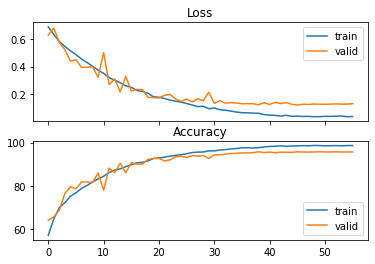

In [24]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(final_train_loss)
ax1.plot(final_valid_loss)
ax1.legend(['train', 'valid'])
ax1.set_title('Loss')

ax2.plot(final_train_acc)
ax2.plot(final_valid_acc)
ax2.legend(['train', 'valid'])
ax2.set_title('Accuracy')

## 추론

In [25]:
submission = pd.read_csv("./face_image/submission_v1.1.csv")
submission.head()

5000


,image,label
0,test14200.jpg,NaN
1,test12178.jpg,NaN
2,test12713.jpg,NaN
3,test13712.jpg,NaN
4,test11739.jpg,NaN


In [26]:
test_dataset = TestDataset(submission['image'], transforms_val)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

## 앙상블 - soft voting

In [27]:
import numpy as np
# softmax_0: 0으로 분류할 확률
def softmax_0(score0, score1) :
  exp_a0 = np.exp(score0)
  exp_a1 = np.exp(score1)
  sum_exp = exp_a0+exp_a1
  y = exp_a0 / sum_exp
  return y

# ensemble 시 threshold 설정을 위해 모든 score를 probability로 변환

In [39]:
prob_zero = [0 for _ in range(5000)]
prob_zero_35 = [0 for _ in range(5000)]

n = len(best_models)

for model in best_models:
  model.to(device)
  model.eval() # model load 후, inference를 위한 eval 모드로 다시 설정

  predictions = []
  files = []
  score_list = []

  with torch.no_grad():
    for img_names, images in test_loader:
      images = images.to(device=device, dtype=dtype)
      scores = model(images)
      _, preds = scores.max(dim=1)
      
      files.extend(img_names)
      predictions.extend(preds.squeeze(0).detach().cpu().numpy())
      score_list.extend(scores.squeeze(0).detach().cpu().numpy()) ## score 형태 그대로 리스트에 저장/ 형태 [[3.XXXXXX, -3.XXXXXX], [..], ...]

  for i, score in enumerate(score_list):
    prob_zero[i] += softmax_0(score[0], score[1])

for i in range(5000):
  prob_zero[i] /= n
  prob_zero_35[i] = (prob_zero[i]<0.35)*1

In [35]:
ensemble_sub = pd.DataFrame(columns=submission.columns)
ensemble_sub['image'] = files
ensemble_sub['label'] = prob_zero_35

In [36]:
ensemble_sub.to_csv("./submission_group1.csv", index=False)